# UCI SECOM 데이터분석

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("/workspace/Final_data_fix.csv")

In [3]:
data.shape

(1567, 373)

In [4]:
# 종속과 독립 데이터 분리
x = data.iloc[:,:372]
y = data.iloc[:, 372]

In [5]:
print(x.shape)
print(y.shape)

(1567, 372)
(1567,)


In [6]:
# 샘플링 별 비교를 위한 train 모델과 test 모델 생성
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 0)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1253, 372)
(314, 372)
(1253,)
(314,)


In [7]:
# 표준화 
from sklearn.preprocessing import StandardScaler

SC = StandardScaler()

x_train = SC.fit_transform(x_train)
x_test = SC.transform(x_test)

## 1. UnderSampling을 통한 데이터 분석

In [8]:
# Under Sampling

failed_tests = np.array(data[data['Pass/Fail'] == 1].index)
no_failed_tests = len(failed_tests)

print(no_failed_tests)

104


In [9]:
normal_indices = data[data['Pass/Fail'] == -1]
no_normal_indices = len(normal_indices)

print(no_normal_indices)

1463


In [10]:
random_normal_indices = np.random.choice(no_normal_indices, size = no_failed_tests, replace = True)
random_normal_indices = np.array(random_normal_indices)

print(len(random_normal_indices))

104


In [11]:
under_sample = np.concatenate([failed_tests, random_normal_indices])
print(len(under_sample))

208


In [12]:
undersample_data = data.iloc[under_sample, :]

In [13]:
# train test 셋 분리를 위한 x,y 분리

x = undersample_data.iloc[:, undersample_data.columns != 'Pass/Fail']
y = undersample_data.iloc[:, undersample_data.columns == 'Pass/Fail']

In [14]:
from sklearn.model_selection import train_test_split

x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x, y, test_size = 0.2, random_state = 0)

print(x_train_us.shape)
print(x_test_us.shape)
print(y_train_us.shape)
print(y_test_us.shape)

(166, 372)
(42, 372)
(166, 1)
(42, 1)


In [15]:
# 표준화

from sklearn.preprocessing import StandardScaler

SC = StandardScaler()
x_train = SC.fit_transform(x_train_us)
x_test = SC.transform(x_test_us)

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_us = le.fit_transform(y_train_us)

c:\python38\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

model = XGBClassifier()

model.fit(x_train_us, y_train_us)

y_pred = model.predict(x_test_us)

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = model.predict(x_test_us)
y_pred = le.inverse_transform(y_pred)
CM = confusion_matrix(y_test_us, y_pred)
print(CM)
accuracy_score(y_test_us, y_pred)

[[13  8]
 [ 2 19]]


0.7619047619047619

<Axes: >

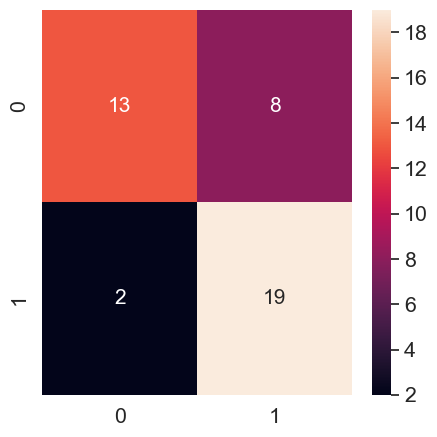

In [19]:
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(y_test_us, y_pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(CM, annot = True, annot_kws = {"size": 15})

In [20]:
from sklearn.model_selection import GridSearchCV

parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6]}]

grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', cv = 2, n_jobs = -1)

grid_search = grid_search.fit(x_train_us, y_train_us)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [21]:

print("Best Accuracy: ", best_accuracy)
print("Best Parameter: ", best_parameters)

Best Accuracy:  0.6867469879518072
Best Parameter:  {'max_depth': 5}


In [22]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

weights = (y == 0).sum()/(1.0*(y == -1).sum())
model = XGBClassifier(max_depth = 4, scale_pos_weights = weights, n_jobs = 4)

model.fit(x_train_us, y_train_us)

y_pred = model.predict(x_test_us)

[09:47:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "scale_pos_weights" } are not used.



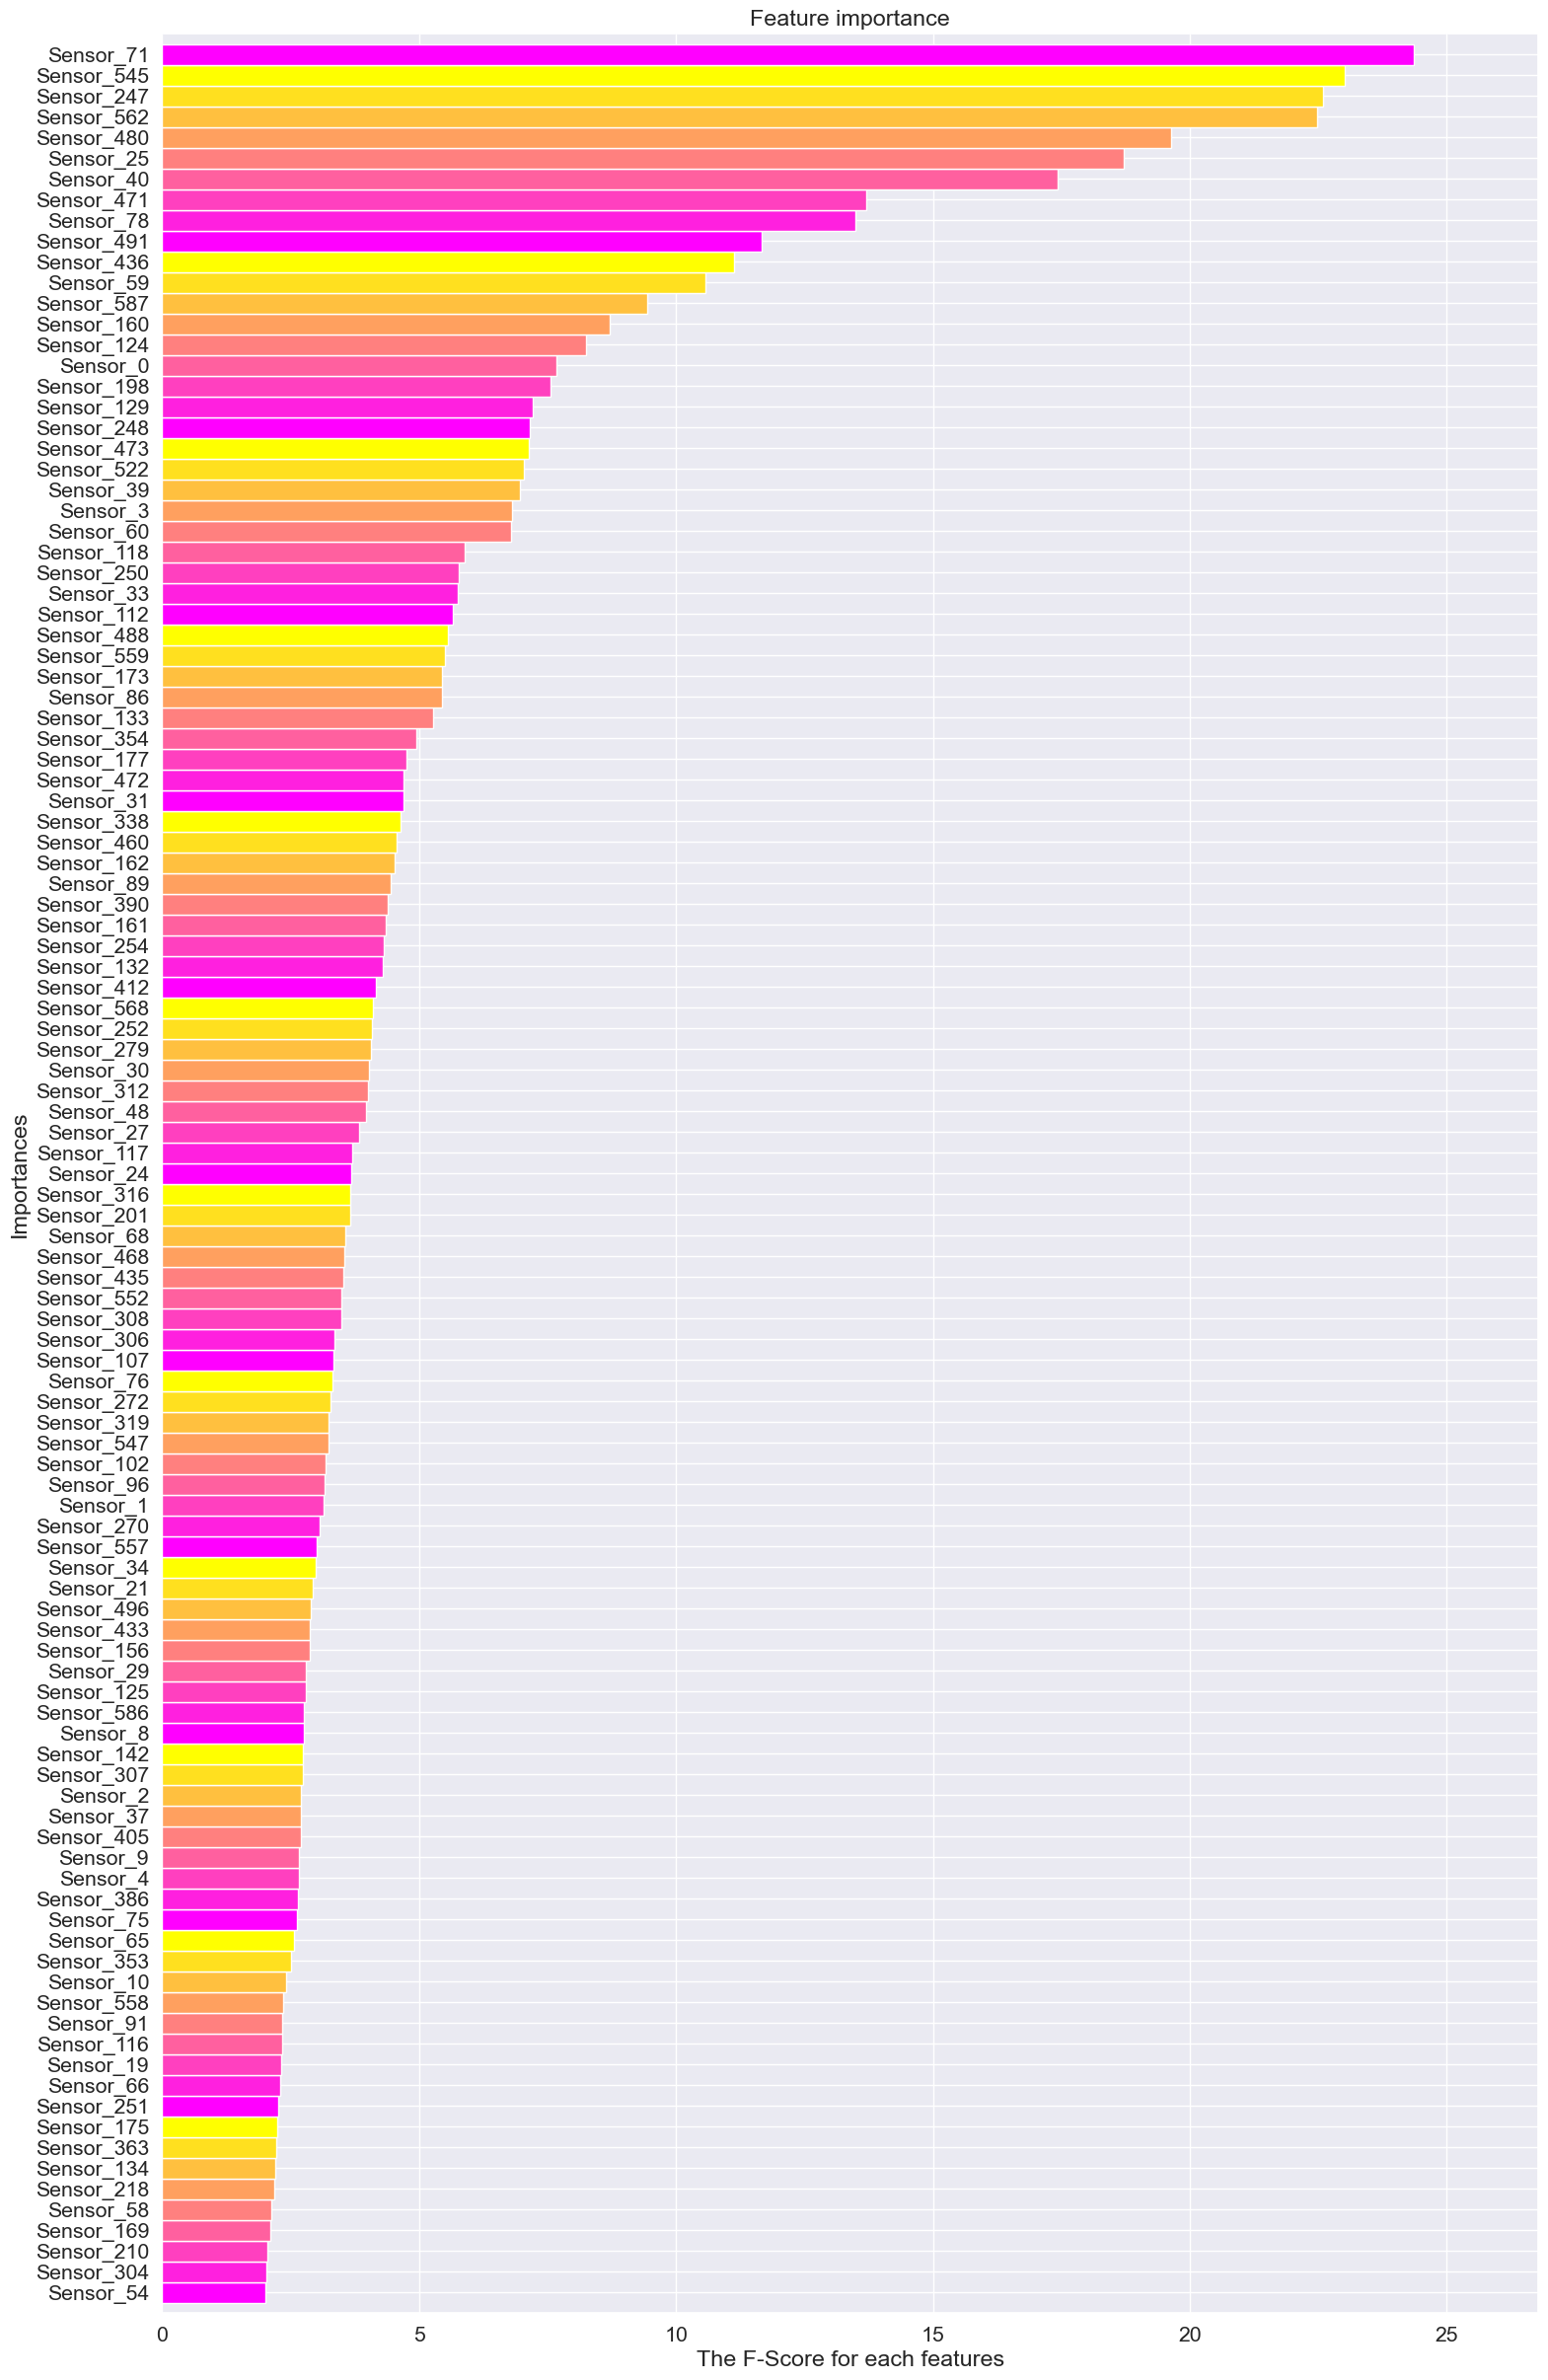

In [27]:
colors = plt.cm.spring(np.linspace(0, 1, 9))
xgb.plot_importance(model, height = 1, color = colors, grid = True, importance_type = 'cover', show_values = False)

plt.rcParams['figure.figsize'] = (18, 300)
plt.xlabel('The F-Score for each features')
plt.ylabel('Importances')
plt.show()

## 2. Over-Sampling 분석

In [24]:
from imblearn.over_sampling import SMOTE

x_resample, y_resample  = SMOTE().fit_resample(x, y.values.ravel())

print(x_resample.shape)
print(y_resample.shape)

(208, 372)
(208,)


In [25]:
from sklearn.model_selection import train_test_split

x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(x, y, test_size = 0.2, random_state = 0)

print(x_train_os.shape)
print(y_train_os.shape)
print(x_test_os.shape)
print(y_test_os.shape)

(166, 372)
(166, 1)
(42, 372)
(42, 1)


In [26]:
#표준화
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train_os = sc.fit_transform(x_train_os)
x_test_os = sc.transform(x_test_os)

In [27]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_os = le.fit_transform(y_train_os)

c:\python38\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

model = XGBClassifier()

model.fit(x_train_os, y_train_os)

y_pred = model.predict(x_test_os)

In [29]:
from sklearn.model_selection import GridSearchCV

# making a parameters list
parameters = [{'max_depth' : [1, 10, 5, 7]}]

# making a grid search model
grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', cv = 2, n_jobs = -1)
grid_search = grid_search.fit(x_train_os, y_train_os)

# getting the results
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [30]:

print("Best Accuracy: ", best_accuracy)
print("Best Parameter: ", best_parameters)

Best Accuracy:  0.7168674698795181
Best Parameter:  {'max_depth': 1}


In [31]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

weights = (y == 0).sum()/(1.0*(y == -1).sum())
model = XGBClassifier(max_depth = 10, scale_pos_weights = weights, n_jobs = 4)

model.fit(x_train_os, y_train_os)

y_pred = model.predict(x_test_os)

[12:44:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "scale_pos_weights" } are not used.



In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = model.predict(x_test_os)
y_pred = le.inverse_transform(y_pred)
CM = confusion_matrix(y_test_os, y_pred)
print(CM)
accuracy_score(y_test_os, y_pred)

[[19  2]
 [ 2 19]]


0.9047619047619048

<Axes: >

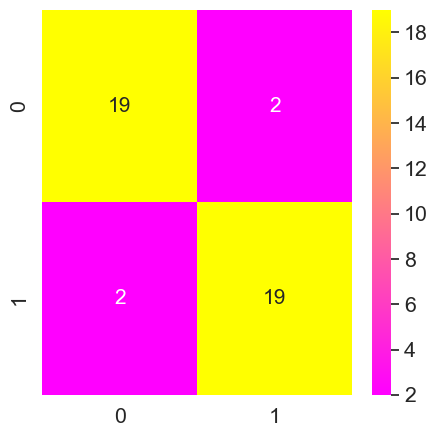

In [33]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_os, y_pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15}, cmap = 'spring')

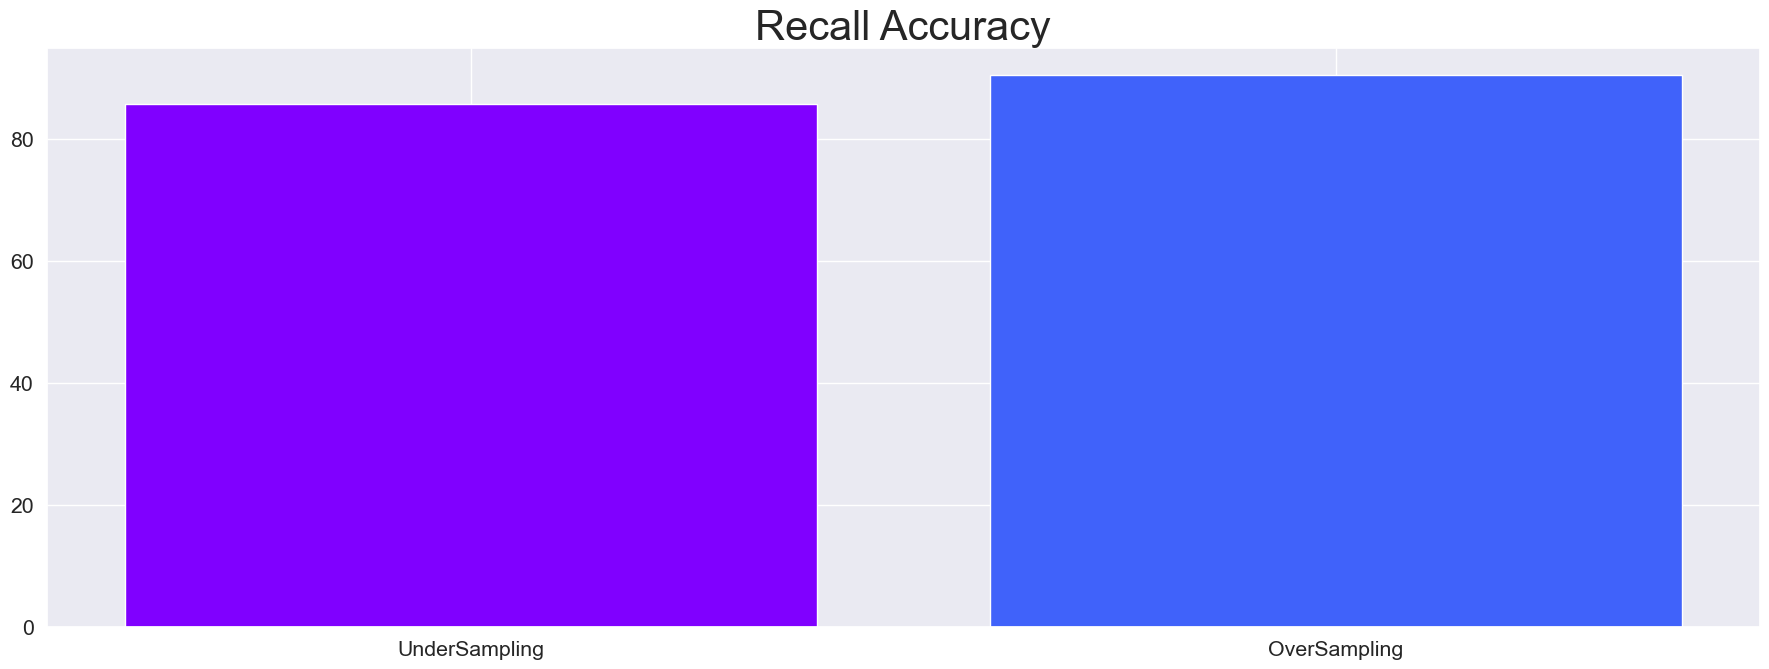

In [34]:
Recall = np.array([85.7, 90.4])
label = np.array(['UnderSampling', 'OverSampling'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), Recall[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title('Recall Accuracy', fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()